<a href="https://colab.research.google.com/github/robinjacobroy/tree_counting/blob/main/Copy_of_tutorial118_binary_semantic_segmentation_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/oBIkr7CAE6g

Binary semantic segmentation using U-Net
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

In [4]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from glob import glob

In [2]:
#Download the mask
!gdown https://drive.google.com/uc?id=1IL3tmUflRJ2jLMI2Aa6Fpt9-XWukLf4S
#Download the RGB image
!gdown https://drive.google.com/uc?id=1hOtL1U3q3vT9hfwn1u8XjbFgqJfmmBUZ

Downloading...
From: https://drive.google.com/uc?id=1IL3tmUflRJ2jLMI2Aa6Fpt9-XWukLf4S
To: /content/mask.png
100% 875k/875k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hOtL1U3q3vT9hfwn1u8XjbFgqJfmmBUZ
To: /content/rgb_good_2.png
100% 60.4M/60.4M [00:00<00:00, 180MB/s]


(500, 500, 3) (500, 500)


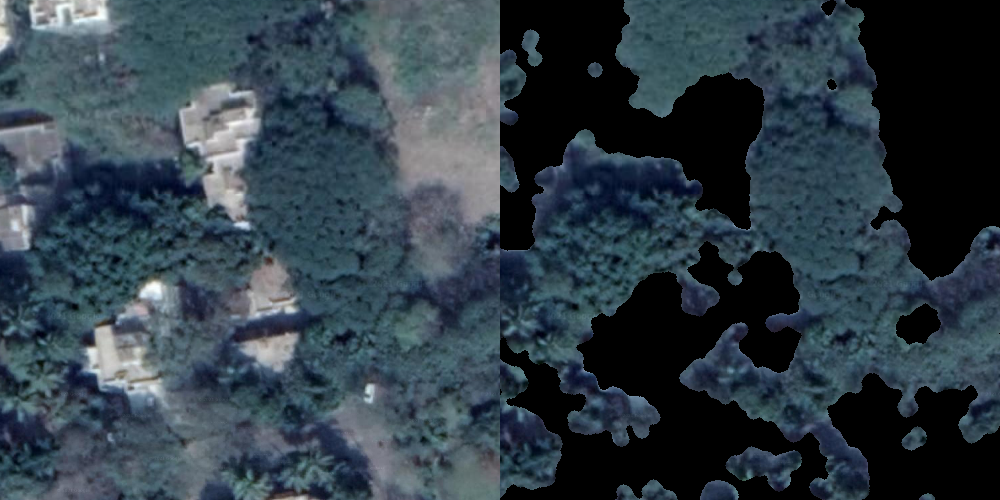

In [4]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('rgb_good_2.png')[1500:2000, 1500:2000]
img2 = cv2.imread('mask_final.png',0)[1500:2000, 1500:2000]
print(img.shape, img2.shape)
cv2_imshow(cv2.hconcat([img, cv2.bitwise_and(img, img, mask=img2)]))

###New augmentation

In [5]:
!mkdir images masks

#crop images into patches
import cv2
import os
from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, RandomRotate90, HorizontalFlip, VerticalFlip

save_path = "./"
img = cv2.imread('rgb_good_2.png')
mask = cv2.imread('mask_final.png')

for j in tqdm(range(300)):
  aug = RandomCrop(height=512, width=512, p=1.0)
  augmented = aug(image=img, mask=mask)
  x = augmented['image']
  y = augmented['mask']

  aug = RandomRotate90(p=1.0)
  augmented = aug(image=x, mask=y)
  x1 = augmented['image']
  y1 = augmented['mask']

  aug = HorizontalFlip(p=1.0)
  augmented = aug(image=x, mask=y)
  x2 = augmented['image']
  y2 = augmented['mask']

  aug = VerticalFlip(p=1.0)
  augmented = aug(image=x, mask=y)
  x3 = augmented['image']
  y3 = augmented['mask']

  save_images = [x, x1, x2, x3]
  save_masks =  [y, y1, y2, y3]

  """ Saving the image and mask. """
  
  idx = 0
  for i, m in zip(save_images, save_masks):
    tmp_img_name = f"{j}_{idx}.png"
    tmp_mask_name = f"{j}_{idx}.png"

    image_path = os.path.join(save_path, "images", tmp_img_name)
    mask_path = os.path.join(save_path, "masks", tmp_mask_name)

    cv2.imwrite(image_path, i)
    cv2.imwrite(mask_path, m)
    idx+=1

100%|██████████| 300/300 [00:24<00:00, 12.13it/s]


###previous augmentation


In [ ]:
!mkdir rgb masks
#crop images into patches
from albumentations import RandomCrop
from tqdm import tqdm
import cv2
img = cv2.imread('rgb_good_2.png')
mask = cv2.imread('mask_final.png')

for i in tqdm(range(100)):
  aug = RandomCrop(height=512, width=512, p=1.0)
  augmented = aug(image=img, mask=mask)
  x = augmented['image']
  y = augmented['mask']
  cv2.imwrite(f'rgb/{i}.png', x)
  cv2.imwrite(f'masks/{i}.png', y)


100%|██████████| 100/100 [00:02<00:00, 47.63it/s]


In [ ]:

!mkdir -p augmented_ims/images
!mkdir -p augmented_ims/masks

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import RandomRotate90, HorizontalFlip, VerticalFlip

def load_data(path):
     images = sorted(glob("rgb/*.png"))     
     masks = sorted(glob('masks/*.png'))
     return images, masks

def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            save_images = [x, x2, x4, x5]
            save_masks =  [y, y2, y4, y5]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"

            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


imgs, msks = load_data("./")
augment_data(imgs, msks, "augmented_ims", augment=True)

100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


###back to code

In [1]:
SIZE = 512
num_images = 500

Load images and masks in order so they match

In [5]:
image_names = glob("images/*.png")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img) for img in image_names_subset]
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

Read masks the same way. 

In [6]:
mask_names = glob("masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [7]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [8]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (500, 512, 512, 3)
Mask data shape is:  (500, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [9]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)
del image_dataset, mask_dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_val), len(X_test))

360 90 50


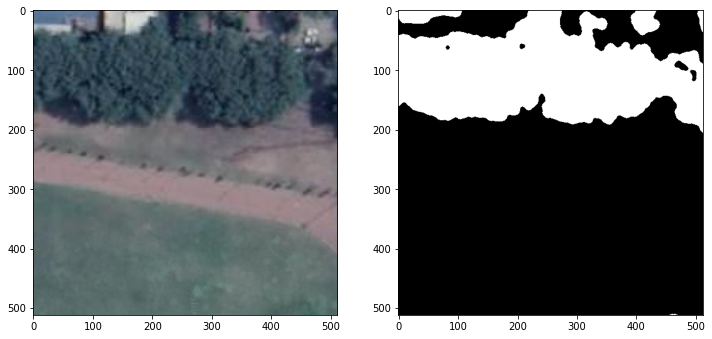

In [11]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number][...,::-1])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [12]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from keras import callbacks



def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape=(512,512,3), n_classes=1):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [13]:
es = [
        callbacks.EarlyStopping(
            
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        mode = 'max',
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=5,
        verbose=1,
    )
]
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model = build_unet()#input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [14]:
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=12, 
                    validation_data=(X_val, y_val), 
                    callbacks=[es,mc],
                    shuffle=False)


Epoch 1/12
90/90 [==============================] - 393s 4s/step - loss: 0.1862 - accuracy: 0.9199 - val_loss: 0.7770 - val_accuracy: 0.5964
Epoch 2/12
90/90 [==============================] - 343s 4s/step - loss: 0.1595 - accuracy: 0.9306 - val_loss: 1.4051 - val_accuracy: 0.5964
Epoch 3/12
90/90 [==============================] - 343s 4s/step - loss: 0.1543 - accuracy: 0.9325 - val_loss: 0.9478 - val_accuracy: 0.6006
Epoch 4/12
90/90 [==============================] - 343s 4s/step - loss: 0.1531 - accuracy: 0.9331 - val_loss: 0.9577 - val_accuracy: 0.6466
Epoch 5/12
90/90 [==============================] - 343s 4s/step - loss: 0.1500 - accuracy: 0.9343 - val_loss: 0.3907 - val_accuracy: 0.7808
Epoch 6/12
90/90 [==============================] - 343s 4s/step - loss: 0.1487 - accuracy: 0.9348 - val_loss: 0.4725 - val_accuracy: 0.8169
Epoch 7/12
90/90 [==============================] - 343s 4s/step - loss: 0.1462 - accuracy: 0.9357 - val_loss: 0.2084 - val_accuracy: 0.8963
Epoch 8/12
90

In [15]:
#Save the model for future use
model.save('12epochs.hdf5')

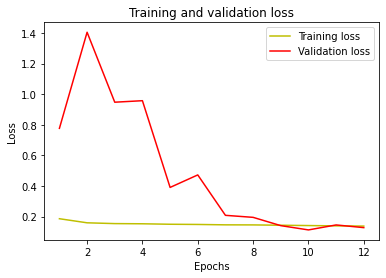

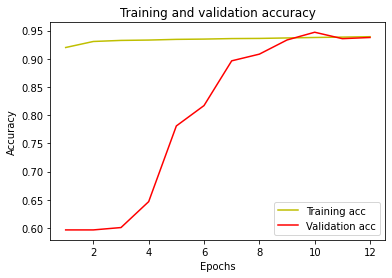

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
#Load previously saved model
from keras.models import load_model
#model = load_model("test.hdf5", compile=False)
#model = load_model("test.hdf5", compile=False)
model.load_weights('12epochs.hdf5')    

In [18]:
#IOU
y_pred=model.predict(X_test[:4,...])
y_pred_thresholded = y_pred > 0.5

In [19]:
from tensorflow.keras.metrics import MeanIoU

In [20]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test[:4,...])
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8813133


(1, 512, 512, 3)
(512, 512)


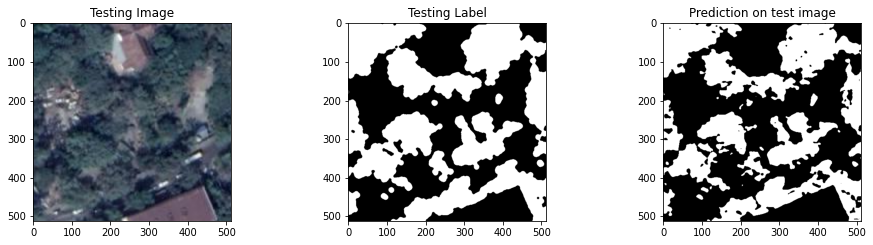

In [21]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[...,::-1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

##Predict on an external image

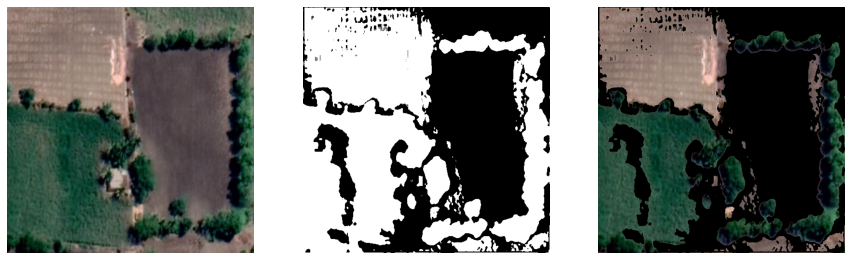

In [23]:
test_img = cv2.imread("image.png")#[:512,:512]
test_img = cv2.resize(test_img, (512,512), interpolation=cv2.INTER_AREA)
test_img = test_img/255.
test_img_input=np.expand_dims(test_img, 0)
#print(test_img_input.shape)
prediction = (model.predict(test_img_input) > 0.01).astype(np.uint8)
#print(prediction.shape)
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
ax0.axis("off")
ax0.imshow(test_img[...,::-1])
ax1.axis("off")
ax1.imshow(prediction[0,:,:,0], cmap='gray')
ax2.axis("off")
ax2.imshow(cv2.bitwise_and(test_img, test_img,\
                mask=prediction[0,:,:,0])[...,::-1]);